In [1]:
# =============================================================================
# CELL 1: Project Setup and Imports
# =============================================================================
"""
Historical Image Colorization - Data Preparation Notebook
This notebook prepares historical images for colorization training
"""

import os
import sys
import glob
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import yaml

# Add src directory to path for imports
sys.path.append('../')
from src.utils import create_directories, rgb_to_lab, get_historical_color_palette

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")


✓ All imports successful!
PyTorch version: 2.8.0+cpu


In [2]:
# =============================================================================
# CELL 2: Define Paths and Configuration
# =============================================================================

# Base project directory (adjust according to your structure)
BASE_DIR = 'D:/colorization_task2/historical-colorization/colorization'
RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed') 
TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'train')
VAL_DIR = os.path.join(BASE_DIR, 'data', 'validation')

# Data configuration
IMAGE_SIZE = 256
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
HISTORICAL_PERIOD = '1920s'  # Change as needed

# Create necessary directories
create_directories(BASE_DIR)

print(f"Base directory: {BASE_DIR}")
print(f"Raw images directory: {RAW_DIR}")
print(f"Processed images directory: {PROCESSED_DIR}")
print(f"Training directory: {TRAIN_DIR}")
print(f"Validation directory: {VAL_DIR}")


Created directory: D:/colorization_task2/historical-colorization/colorization\data/raw
Created directory: D:/colorization_task2/historical-colorization/colorization\data/processed
Created directory: D:/colorization_task2/historical-colorization/colorization\data/train
Created directory: D:/colorization_task2/historical-colorization/colorization\data/validation
Created directory: D:/colorization_task2/historical-colorization/colorization\outputs/colorized
Created directory: D:/colorization_task2/historical-colorization/colorization\outputs/samples
Created directory: D:/colorization_task2/historical-colorization/colorization\models
Created directory: D:/colorization_task2/historical-colorization/colorization\checkpoints
Created directory: D:/colorization_task2/historical-colorization/colorization\logs
Base directory: D:/colorization_task2/historical-colorization/colorization
Raw images directory: D:/colorization_task2/historical-colorization/colorization\data\raw
Processed images directo

Found 10 raw images
✓ Images found successfully!


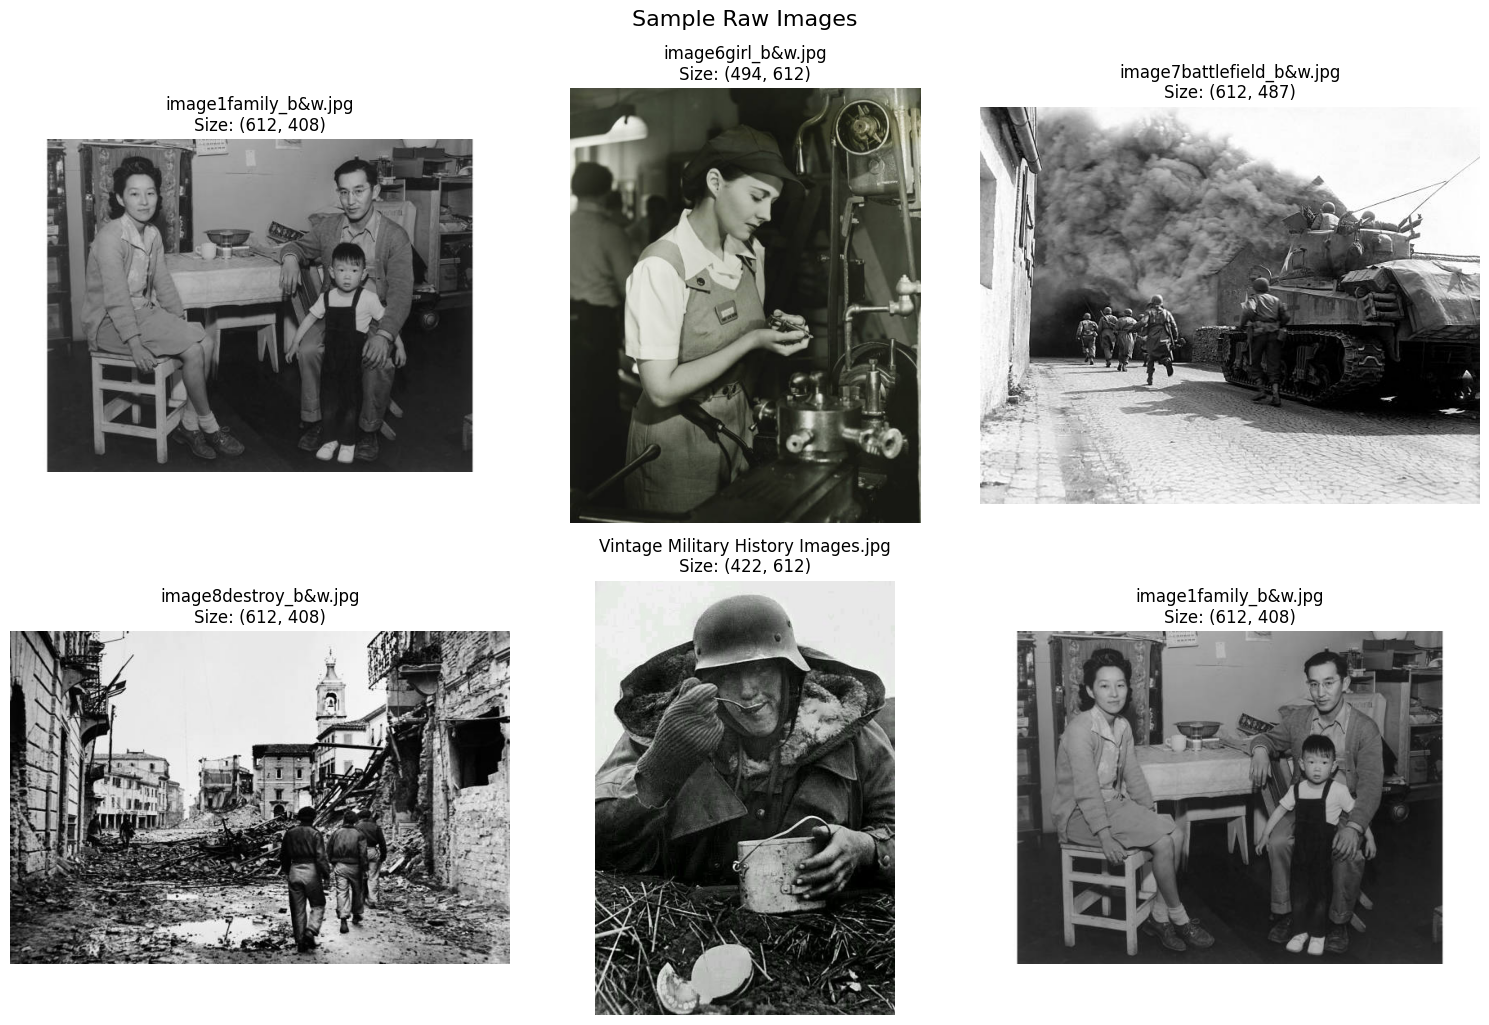

In [3]:
# =============================================================================
# CELL 3: Explore Raw Dataset
# =============================================================================

# Find all image files in raw directory
supported_formats = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
raw_images = []

for format_type in supported_formats:
    raw_images.extend(glob.glob(os.path.join(RAW_DIR, format_type)))
    raw_images.extend(glob.glob(os.path.join(RAW_DIR, format_type.upper())))

print(f"Found {len(raw_images)} raw images")

if len(raw_images) == 0:
    print("⚠️  No images found in raw directory!")
    print("Please add some historical images to:", RAW_DIR)
else:
    print("✓ Images found successfully!")
    
    # Display sample images if available
    if len(raw_images) > 0:
        # Show first few images
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, img_path in enumerate(raw_images[:6]):
            if i >= 6:
                break
                
            try:
                img = Image.open(img_path).convert('RGB')
                axes[i].imshow(img)
                axes[i].set_title(f"{os.path.basename(img_path)}\nSize: {img.size}")
                axes[i].axis('off')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                
        plt.tight_layout()
        plt.suptitle("Sample Raw Images", fontsize=16, y=1.02)
        plt.show()


In [4]:
# =============================================================================
# CELL 4: Image Preprocessing and Quality Check - FULLY FIXED
# =============================================================================

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Preprocess a single image: resize with aspect ratio, center on white canvas.
    FIXED VERSION - corrects the tuple subtraction error
    """
    try:
        # Load and convert to RGB
        img = Image.open(image_path).convert('RGB')
        original_size = img.size  # (width, height)

        # Resize with aspect ratio
        img.thumbnail(target_size, Image.Resampling.LANCZOS)

        # Create white canvas and center the resized image
        new_img = Image.new('RGB', target_size, (255, 255, 255))
        
        # FIXED: Properly access width and height from tuple
        paste_x = (target_size[0] - img.size[0]) // 2  # Fixed: img.size[0] instead of img.size
        paste_y = (target_size[1] - img.size[1]) // 2  # Fixed: img.size[1] instead of img.size
        new_img.paste(img, (paste_x, paste_y))

        return new_img, original_size

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

print("Processing images...")
processed_count = 0
failed_count = 0

for i, img_path in enumerate(raw_images, start=1):
    processed_img, orig_size = preprocess_image(img_path, (IMAGE_SIZE, IMAGE_SIZE))
    if processed_img is not None:
        filename = os.path.basename(img_path)
        name, ext = os.path.splitext(filename)
        out_name = f"{name}_processed{ext}"
        out_path = os.path.join(PROCESSED_DIR, out_name)
        processed_img.save(out_path, quality=95)
        processed_count += 1
        if i % 10 == 0 or i == len(raw_images):
            print(f"Processed {i}/{len(raw_images)} images")
    else:
        failed_count += 1

print(f"\n✓ Image preprocessing complete!")
print(f"Successfully processed: {processed_count}")
print(f"Failed to process: {failed_count}")



Processing images...
Processed 10/10 images

✓ Image preprocessing complete!
Successfully processed: 10
Failed to process: 0


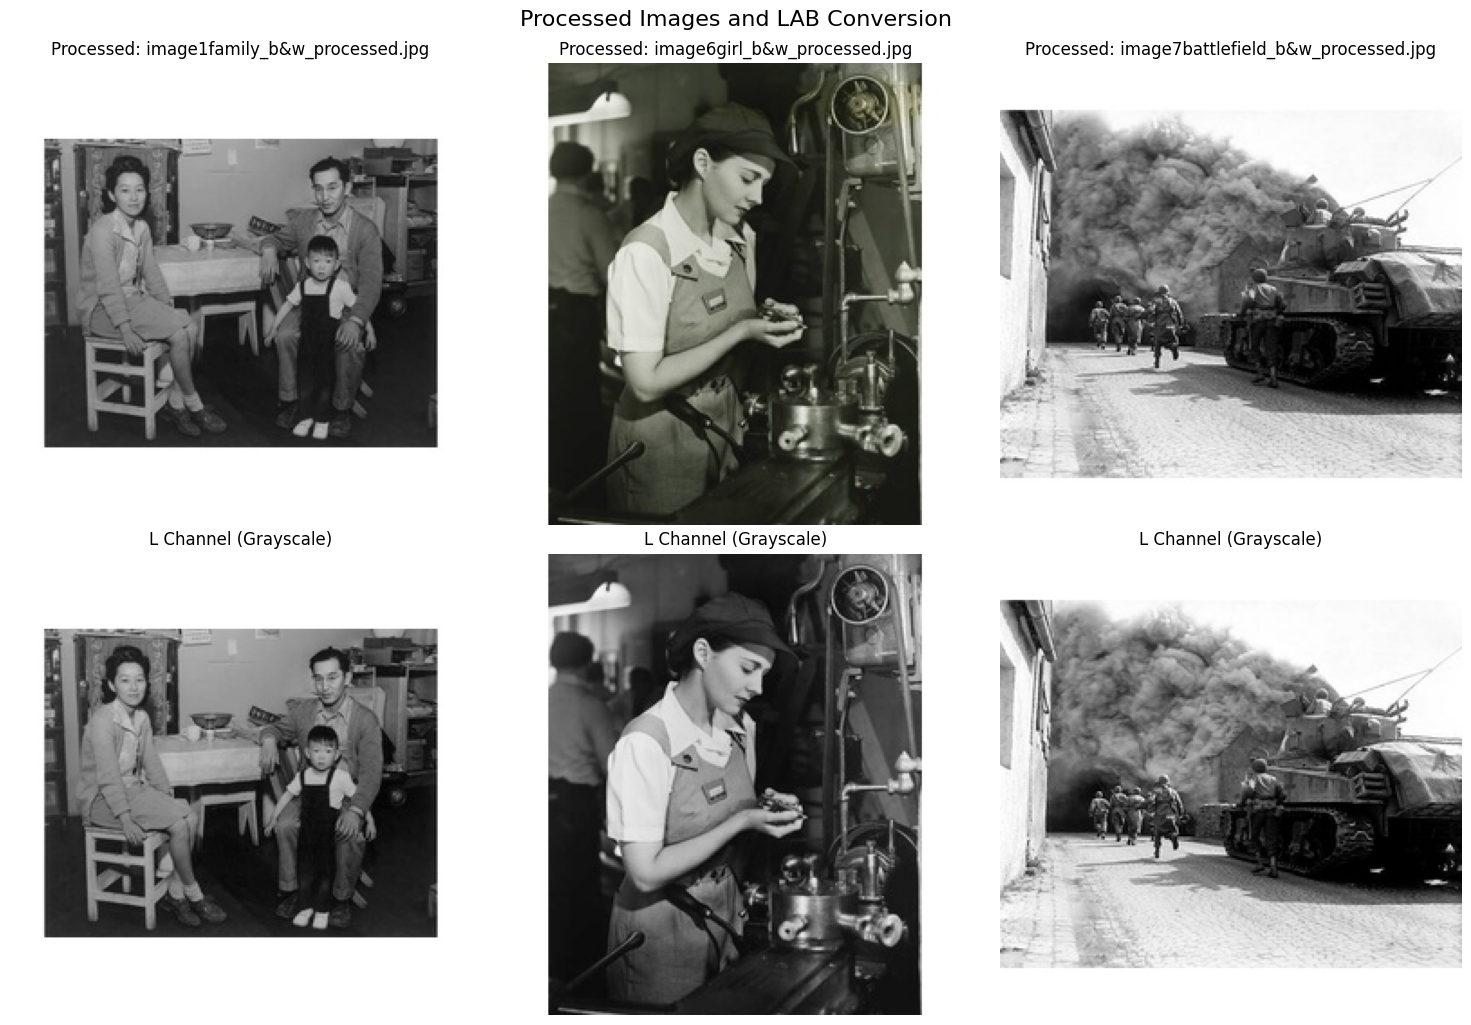

In [5]:
# =============================================================================
# CELL 5: Data Visualization
# =============================================================================

if processed_count > 0:
    # Show before/after preprocessing comparison
    processed_images = glob.glob(os.path.join(PROCESSED_DIR, '*'))
    
    if len(processed_images) >= 3:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        for i in range(min(3, len(processed_images))):
            # Show processed image
            processed_img = Image.open(processed_images[i])
            axes[0, i].imshow(processed_img)
            axes[0, i].set_title(f"Processed: {os.path.basename(processed_images[i])}")
            axes[0, i].axis('off')
            
            # Show LAB conversion example
            processed_tensor = transforms.ToTensor()(processed_img)
            lab_tensor = rgb_to_lab(processed_tensor)
            
            # Show L channel (grayscale)
            axes[1, i].imshow(lab_tensor[0], cmap='gray')
            axes[1, i].set_title(f"L Channel (Grayscale)")
            axes[1, i].axis('off')
            
        plt.tight_layout()
        plt.suptitle("Processed Images and LAB Conversion", fontsize=16, y=1.02)
        plt.show()



In [6]:
# =============================================================================
# CELL 6: Train/Validation Split
# =============================================================================

def create_train_val_split():
    """Create train/validation split from processed images"""
    
    # Get all processed images
    processed_images = glob.glob(os.path.join(PROCESSED_DIR, '*'))
    
    if len(processed_images) == 0:
        print("No processed images found for splitting!")
        return
    
    # Split into train and validation
    train_images, val_images = train_test_split(
        processed_images, 
        train_size=TRAIN_SPLIT,
        random_state=42
    )
    
    print(f"Training images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")
    
    # Copy images to respective directories
    for img_path in train_images:
        filename = os.path.basename(img_path)
        dst_path = os.path.join(TRAIN_DIR, filename)
        shutil.copy2(img_path, dst_path)
    
    for img_path in val_images:
        filename = os.path.basename(img_path)
        dst_path = os.path.join(VAL_DIR, filename)
        shutil.copy2(img_path, dst_path)
    
    print(f"✓ Data split complete!")
    print(f"Training data: {TRAIN_DIR}")
    print(f"Validation data: {VAL_DIR}")

# Execute the split
create_train_val_split()



Training images: 4
Validation images: 1
✓ Data split complete!
Training data: D:/colorization_task2/historical-colorization/colorization\data\train
Validation data: D:/colorization_task2/historical-colorization/colorization\data\validation


In [7]:
# =============================================================================
# CELL 7: Dataset Statistics and Summary
# =============================================================================

def analyze_dataset():
    """Analyze the final dataset"""
    
    # Count files in each directory
    train_count = len([f for f in os.listdir(TRAIN_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    val_count = len([f for f in os.listdir(VAL_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    
    print("📊 Dataset Statistics:")
    print(f"Total processed images: {processed_count}")
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")
    print(f"Image size: {IMAGE_SIZE} x {IMAGE_SIZE}")
    print(f"Historical period: {HISTORICAL_PERIOD}")
    
    # Get color palette info
    palette = get_historical_color_palette(HISTORICAL_PERIOD)
    print(f"\n🎨 Color Palette for {HISTORICAL_PERIOD}:")
    print(f"Description: {palette['description']}")
    print(f"Dominant colors: {len(palette['dominant_colors'])} colors")
    print(f"Accent colors: {len(palette['accent_colors'])} colors")
    
    # Show dataset readiness
    if train_count > 0 and val_count > 0:
        print("\n✅ Dataset is ready for training!")
    else:
        print("\n❌ Dataset preparation incomplete!")

# Run analysis
analyze_dataset()

print("\n🎯 Next Steps:")
print("1. Run the training script: python src/train.py")
print("2. Monitor training with tensorboard: tensorboard --logdir logs/")
print("3. Check sample outputs in: outputs/samples/")
print("4. Use trained model for inference on new images")

print("\n📋 Data Preparation Complete!")



📊 Dataset Statistics:
Total processed images: 10
Training images: 4
Validation images: 1
Image size: 256 x 256
Historical period: 1920s

🎨 Color Palette for 1920s:
Description: Art Deco era with metallic golds and rich jewel tones
Dominant colors: 3 colors
Accent colors: 3 colors

✅ Dataset is ready for training!

🎯 Next Steps:
1. Run the training script: python src/train.py
2. Monitor training with tensorboard: tensorboard --logdir logs/
3. Check sample outputs in: outputs/samples/
4. Use trained model for inference on new images

📋 Data Preparation Complete!
